In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
from keras.models import model_from_json
from skimage.transform import resize

Using TensorFlow backend.


No Finding
2
M
81
CHEST
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'


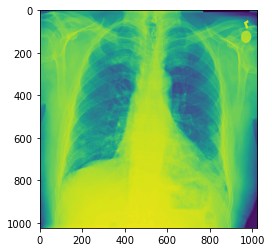

In [2]:
filename = 'test1.dcm'
ds = pydicom.dcmread(filename)
img = ds.pixel_array
img_mean = np.mean(img)
img_std = np.std(img)
print(ds.StudyDescription)
print(ds.PatientID)
print(ds.PatientSex)
print(ds.PatientAge)
print(ds.BodyPartExamined)
plt.imshow(img)
print(ds)

In [3]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    try:
        assert(ds.BodyPartExamined == 'CHEST')
        assert(ds.Modality == 'DX')
        assert(ds.PatientPosition in ['AP', 'PA'])
    except Exception as e:
        print('File {} contains invalid data'.format(filename))
        print(e)
        return None,0,0
    img = ds.pixel_array
    img_mean = np.mean(img)
    img_std = np.std(img)
    print('Patient Id:', ds.PatientID)
    print('Study Description:',ds.StudyDescription)
    print('Patient Gender:', ds.PatientSex)
    print('Patient Age:', ds.PatientAge)
    print('Patient Position:', ds.PatientPosition)
    print('Body Part Examined:', ds.BodyPartExamined)
    return img, img_mean, img_std
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    proc_img = img.copy()
    proc_img = (proc_img - img_mean)/img_std
    proc_img = resize(img, img_size)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_file = open(model_path, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred_Y = model.predict(img, batch_size = 1, verbose = True)
    prediction = ''
    #print(pred_Y)
    if pred_Y[0][0] > thresh:
        prediction = 'Presence of Pneumonia'
    else:
        prediction = 'Absence of Pneumonia'
    return prediction

In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "best_model1.json" #path to saved model
weight_path = "xray_class_best_model.best.hdf5" #path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.9874916 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    img = np.array([])
    img, img_mean, img_std = check_dicom(i)
    
    if img is None:
        continue
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)
    print('-'*50)

Load file test1.dcm ...
Patient Id: 2
Study Description: No Finding
Patient Gender: M
Patient Age: 81
Patient Position: PA
Body Part Examined: CHEST
1/1 [==============================] - 2s 2s/step
Absence of Pneumonia
--------------------------------------------------
Load file test2.dcm ...
Patient Id: 1
Study Description: Cardiomegaly
Patient Gender: M
Patient Age: 58
Patient Position: AP
Body Part Examined: CHEST
1/1 [==============================] - 0s 199ms/step
Absence of Pneumonia
--------------------------------------------------
Load file test3.dcm ...
Patient Id: 61
Study Description: Effusion
Patient Gender: M
Patient Age: 77
Patient Position: AP
Body Part Examined: CHEST
1/1 [==============================] - 0s 206ms/step
Absence of Pneumonia
--------------------------------------------------
Load file test4.dcm ...
File test4.dcm contains invalid data

Load file test5.dcm ...
File test5.dcm contains invalid data

Load file test6.dcm ...
File test6.dcm contains invalid 